# Assignment 2 - Leonardo Stoppani
### Plot the auto-correlogram of the temperature data in the appliances [dataset](https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction#)

## Analysis

### Get Data
First we extract the temperatures data of the 9 sensors.

In [1]:
# import the dataset 
import pandas as pd

#download data from gdrive
url = "https://drive.google.com/uc?id=1iDSkzcs4fmyKFsOGtv9XPev7ieNfwI52"
output = 'energydata_complete.csv'
gdown.download(url, output, quiet=False)

df = pd.read_csv(r'./energydata_complete.csv', parse_dates=['date'], index_col='date')

# define dict for sensors name 
sensors = {1:"Kitchen", 2:"Living", 3:"Laundry", 4:"Office", 5:"Bathroom", 
           6:"Outside North", 7:"Ironing", 8:"Teenager", 9:"Parents",}

print(df.head())

                     Appliances  lights     T1       RH_1    T2       RH_2  \
date                                                                         
2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

                        T3       RH_3         T4       RH_4  ...         T9  \
date                                                         ...              
2016-01-11 17:00:00  19.79  44.730000  19.000000  45.566667  ...  17.033333   
2016-01-11 17:10:00  19.79  44.790000  19.000000  45.992500  ...  17.066667   
2016-01-11 17:20:00  19.79  44.933333  18.926667  45.890000  ...  17.000000   
2016-01-11 17:30:00  19.79  45.000000  18.890000  45.72333

### Plot data
Then we plot the 9 time series for a first look to our data. Sensors data have a lot of noise, so before plotting the auto-correlogram we try to reduce it.

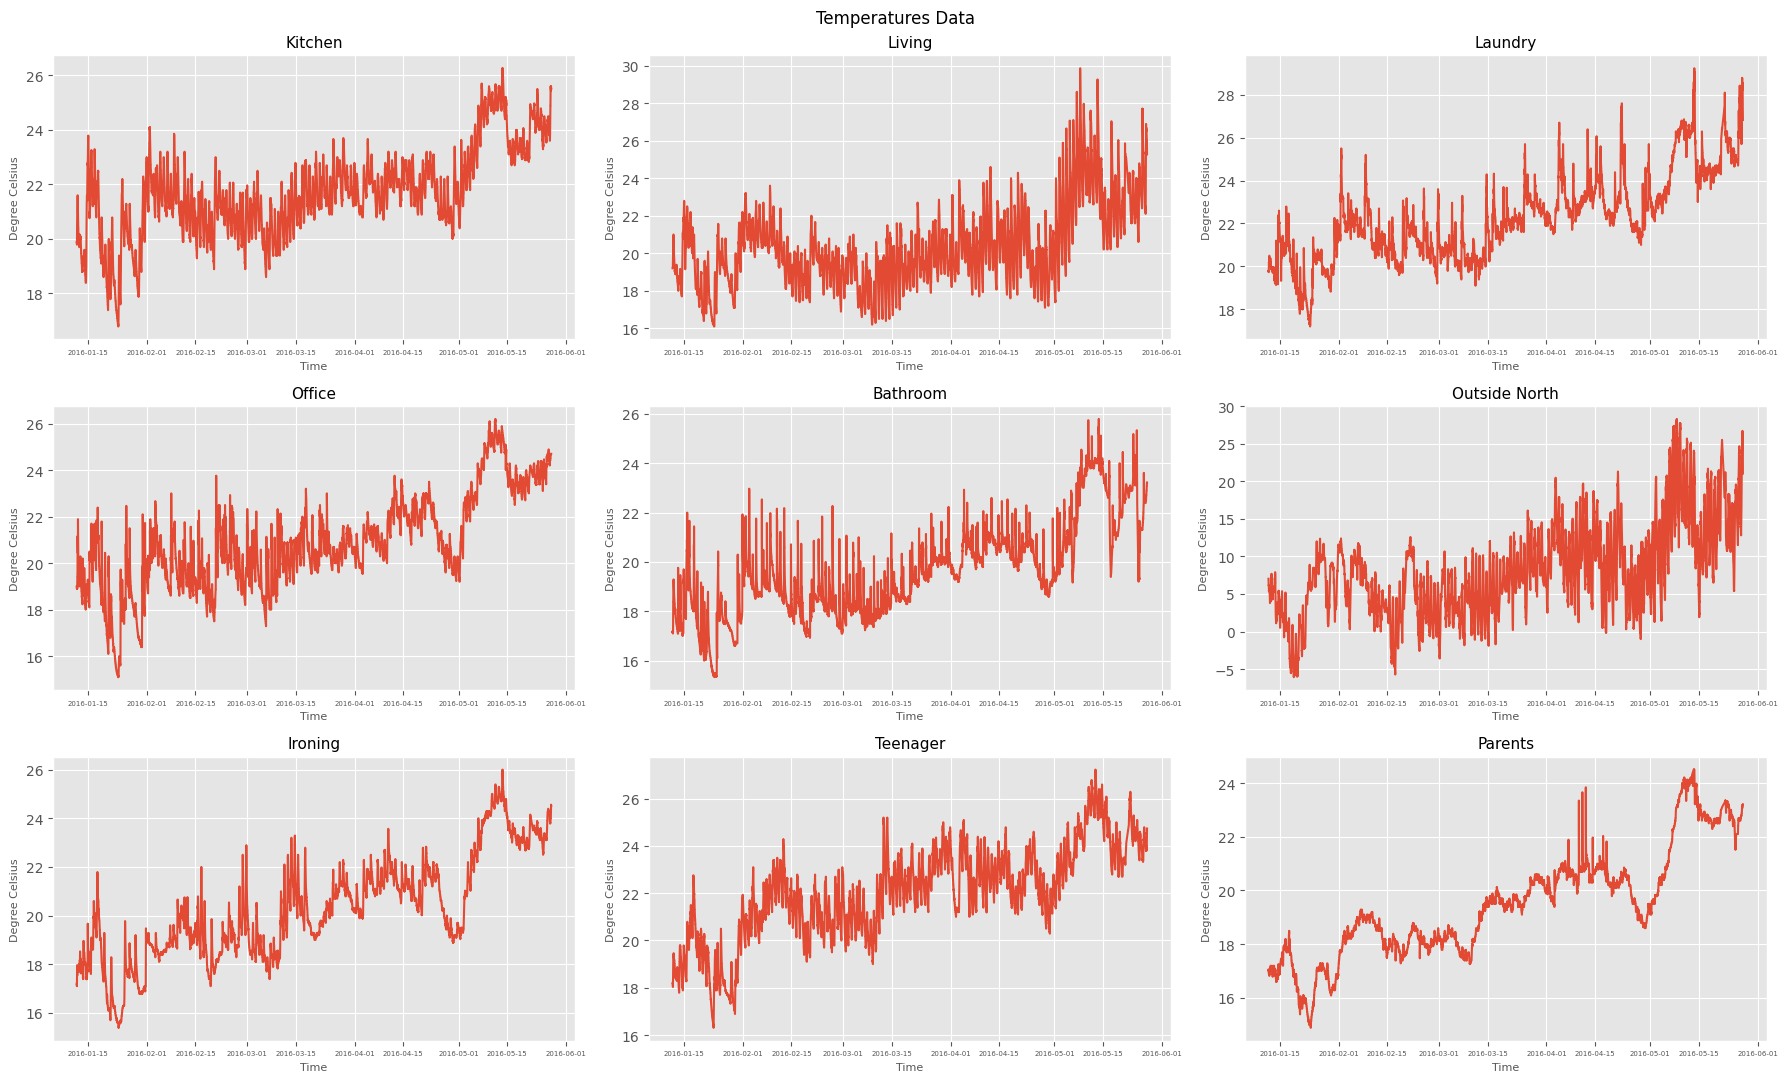

In [2]:
# plot data to understand best lag value (k)
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
import numpy as np

plt.style.use("ggplot")
figure, axis = plt.subplots(3, 3, figsize=(18, 11))

k=0
for i in range(3):
    for j in range(3):
        k+=1
        data = df['T'+str(k)]
        #print(data)
        result = axis[i,j].plot(data)
        axis[i,j].set_title(sensors[k], fontsize=11)
        axis[i,j].set_xlabel("Time", fontsize=8)
        axis[i,j].set_ylabel("Degree Celsius", fontsize=8)
        axis[i,j].tick_params(axis="x", labelsize=5) 

figure.suptitle("Temperatures Data")
figure.tight_layout()
plt.show()


### Clean Data

#### Subsampling
Noise in the data can be caused by the fine grain measurement. Temperature is affected by small variation wich can make difficult to read data, so we make a subsampling moving from 10 minutes intervals to 1 hour and taking the avarege value. We expect to do this without losing too much information and reducing more the noise.

In [3]:
# subsampling 6 row into 1 and take average temperature every hour
df_sub = df.resample('60T').mean() # one line every hour
#print(df_sub.head())
print(df_sub.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3290 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Freq: 60T
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   3290 non-null   float64
 1   lights       3290 non-null   float64
 2   T1           3290 non-null   float64
 3   RH_1         3290 non-null   float64
 4   T2           3290 non-null   float64
 5   RH_2         3290 non-null   float64
 6   T3           3290 non-null   float64
 7   RH_3         3290 non-null   float64
 8   T4           3290 non-null   float64
 9   RH_4         3290 non-null   float64
 10  T5           3290 non-null   float64
 11  RH_5         3290 non-null   float64
 12  T6           3290 non-null   float64
 13  RH_6         3290 non-null   float64
 14  T7           3290 non-null   float64
 15  RH_7         3290 non-null   float64
 16  T8           3290 non-null   float64
 17  RH_8         3290 non-null   float64
 18  T9

#### Remove Trend
All the time series have a trend from lower to higher temperatures, caused by the transition from winter to summer. We need to remove it before study it's periodicity, and in order to get stationariety before perform DFT.

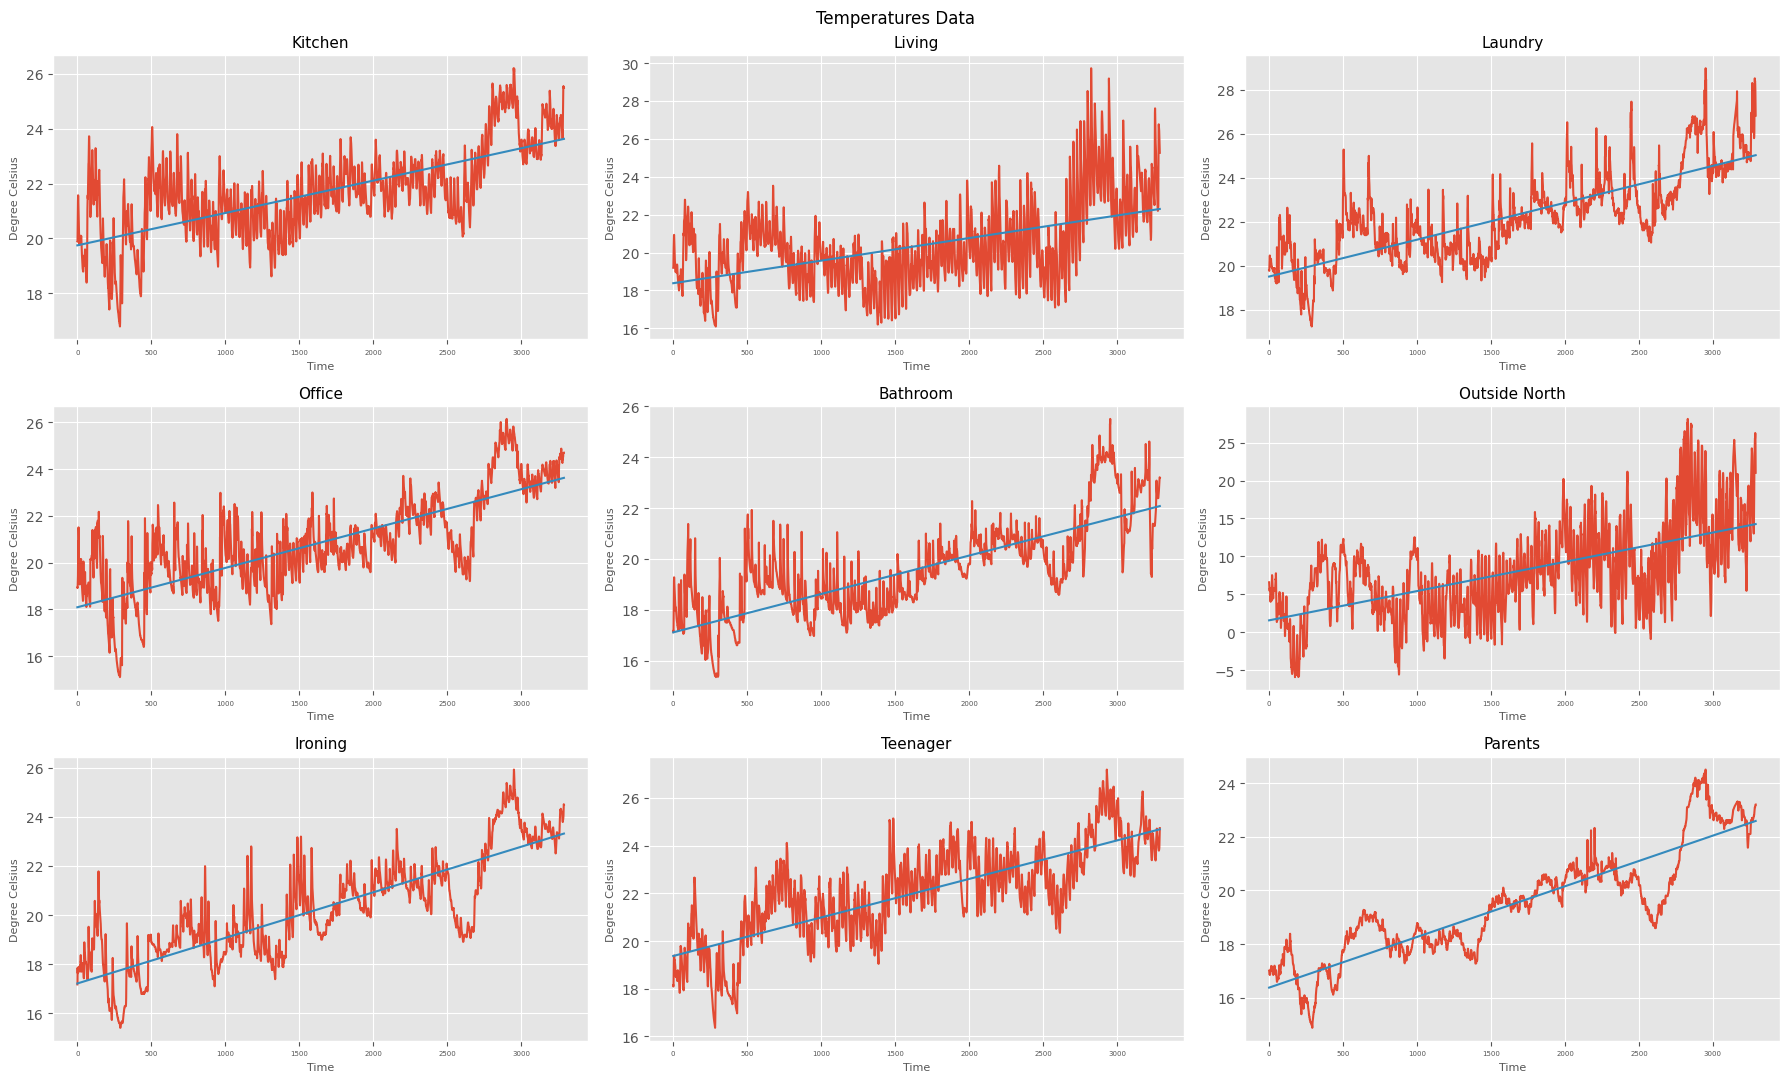

In [4]:
#remove trend
from sklearn.linear_model import LinearRegression

plt.style.use("ggplot")
figure, axis = plt.subplots(3, 3, figsize=(18, 11))

k=0
for i in range(3):
    for j in range(3):
        k+=1
        data = df_sub['T'+str(k)]

        #linear trend
        model = LinearRegression()

        X = np.arange(len(data.index))
        X = np.reshape(X, (len(X),1))
        y = data.values

        model.fit(X,y)
        trend = model.predict(X)

        axis[i,j].plot(y)
        axis[i,j].plot(trend)

        axis[i,j].set_title(sensors[k], fontsize=11)
        axis[i,j].set_xlabel("Time", fontsize=8)
        axis[i,j].set_ylabel("Degree Celsius", fontsize=8)
        axis[i,j].tick_params(axis="x", labelsize=5) 
        

figure.suptitle("Temperatures Data")
figure.tight_layout()
plt.show()

A linear regression seems to fit the trend, now we remove it.

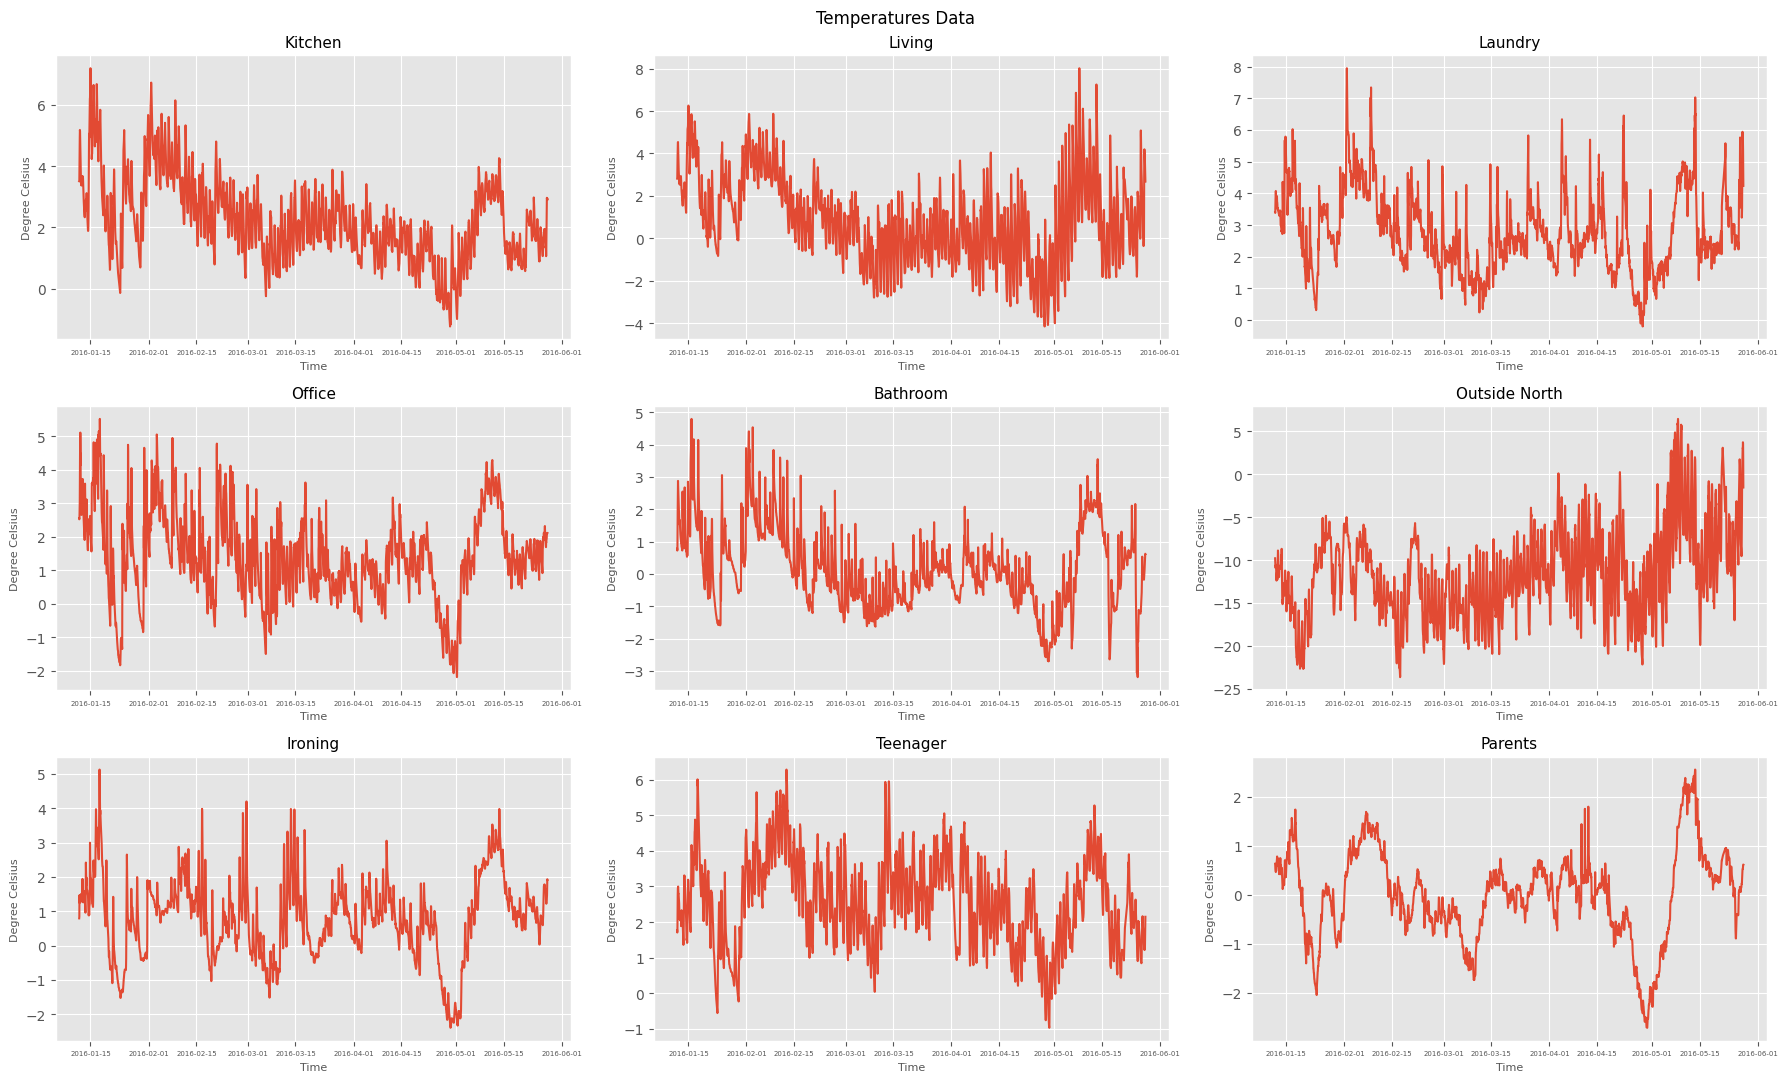

In [5]:
plt.style.use("ggplot")
figure, axis = plt.subplots(3, 3, figsize=(18, 11))

k=0
for i in range(3):
    for j in range(3):
        k+=1

        #remove linear trend
        df_sub['T'+str(k)] = [df_sub['T'+str(k)][i] - trend[i] for i in range(0, len(df_sub['T'+str(k)]))]

        #axis[i,j].plot(y)
        axis[i,j].plot(df_sub['T'+str(k)])

        axis[i,j].set_title(sensors[k], fontsize=11)
        axis[i,j].set_xlabel("Time", fontsize=8)
        axis[i,j].set_ylabel("Degree Celsius", fontsize=8)
        axis[i,j].tick_params(axis="x", labelsize=5) 
        

figure.suptitle("Temperatures Data")
figure.tight_layout()
plt.show()

#### Discrete Fourier Transform
By taking the time series in the frequency domain we can discard the ones which are causing noise, preserve only the relevant frequency, and return in the time domain with cleaned data. 

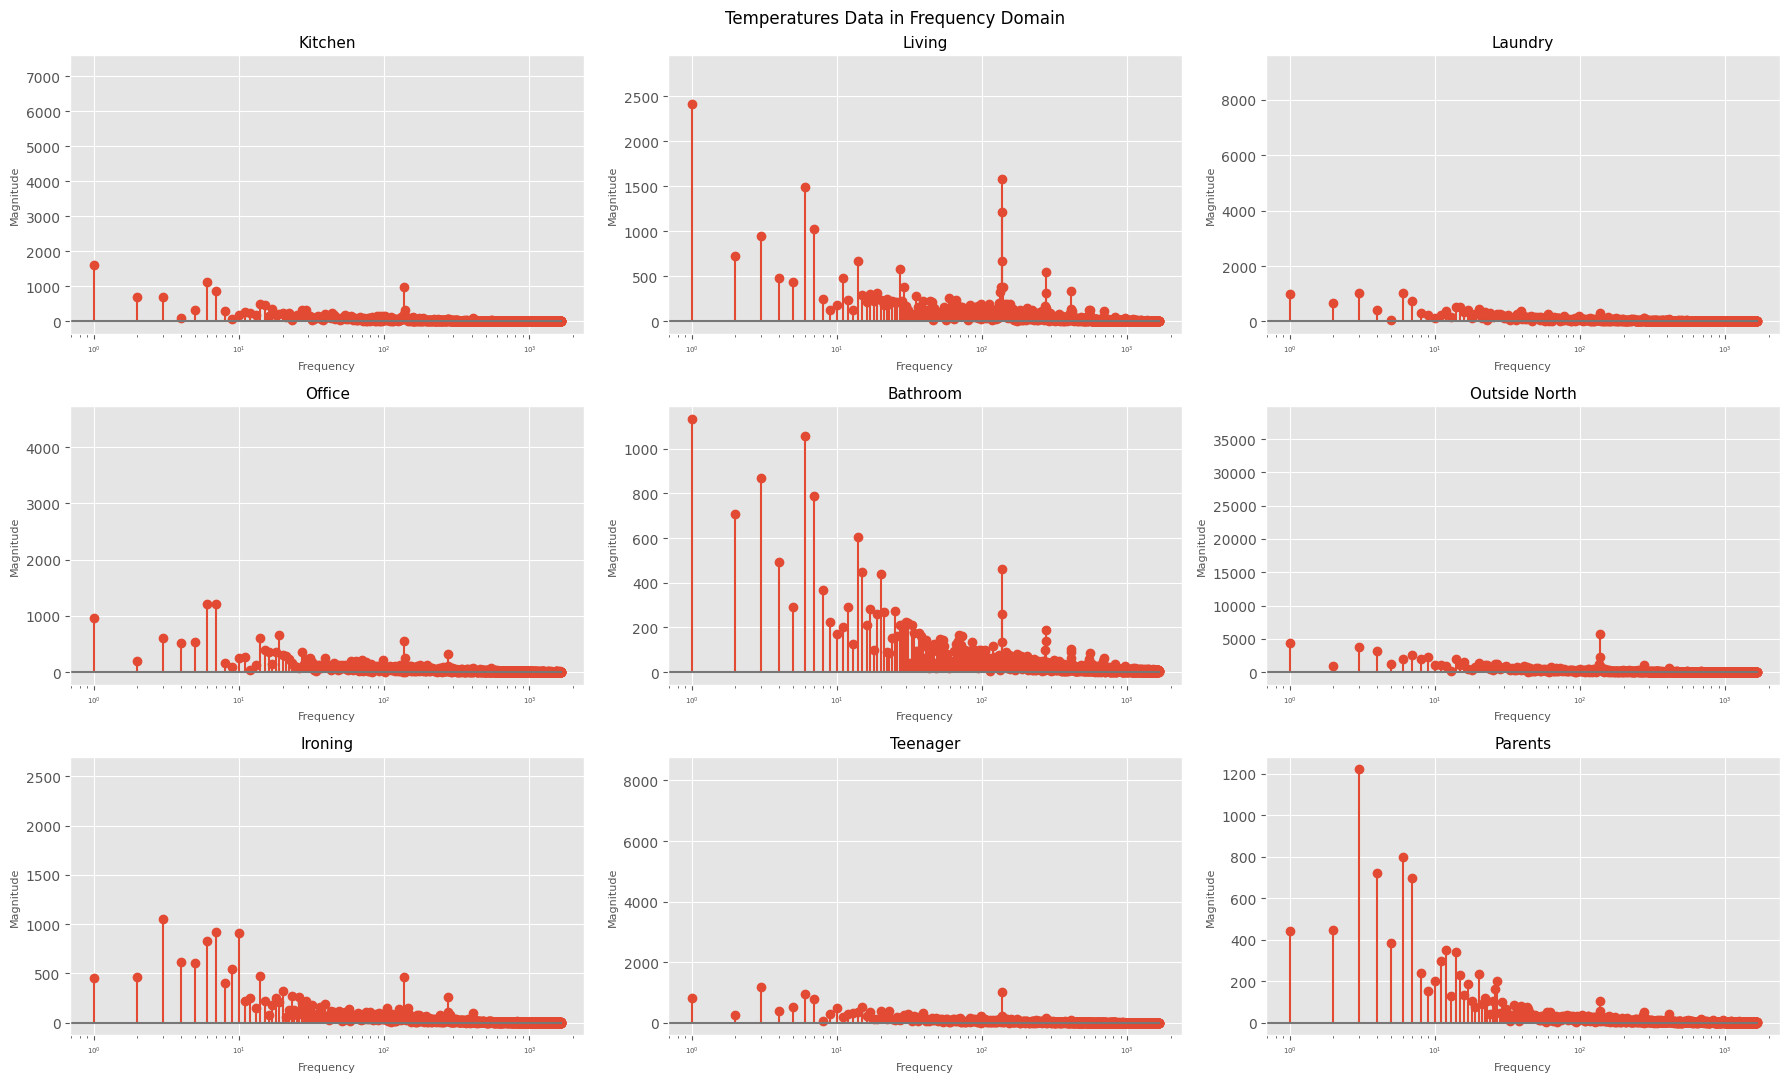

In [49]:
plt.style.use("ggplot")
figure, axis = plt.subplots(3, 3, figsize=(18, 11))

k=0
for i in range(3):
    for j in range(3):
        k+=1
        data = df_sub['T'+str(k)]
        num_samples = len(data.to_numpy())

        #dft
        fft = np.fft.rfft(data.to_numpy(), num_samples)

        axis[i,j].stem(abs(fft))
        #axis[i,j].plot(clean_data)

        axis[i,j].set_title(sensors[k], fontsize=11)
        axis[i,j].set_xlabel("Frequency", fontsize=8)
        axis[i,j].set_ylabel("Magnitude", fontsize=8)
        axis[i,j].tick_params(axis="x", labelsize=5) 
        axis[i,j].set_xscale('log')

figure.suptitle("Temperatures Data in Frequency Domain")
figure.tight_layout()
plt.show()


Zoom in area of one day frequency.

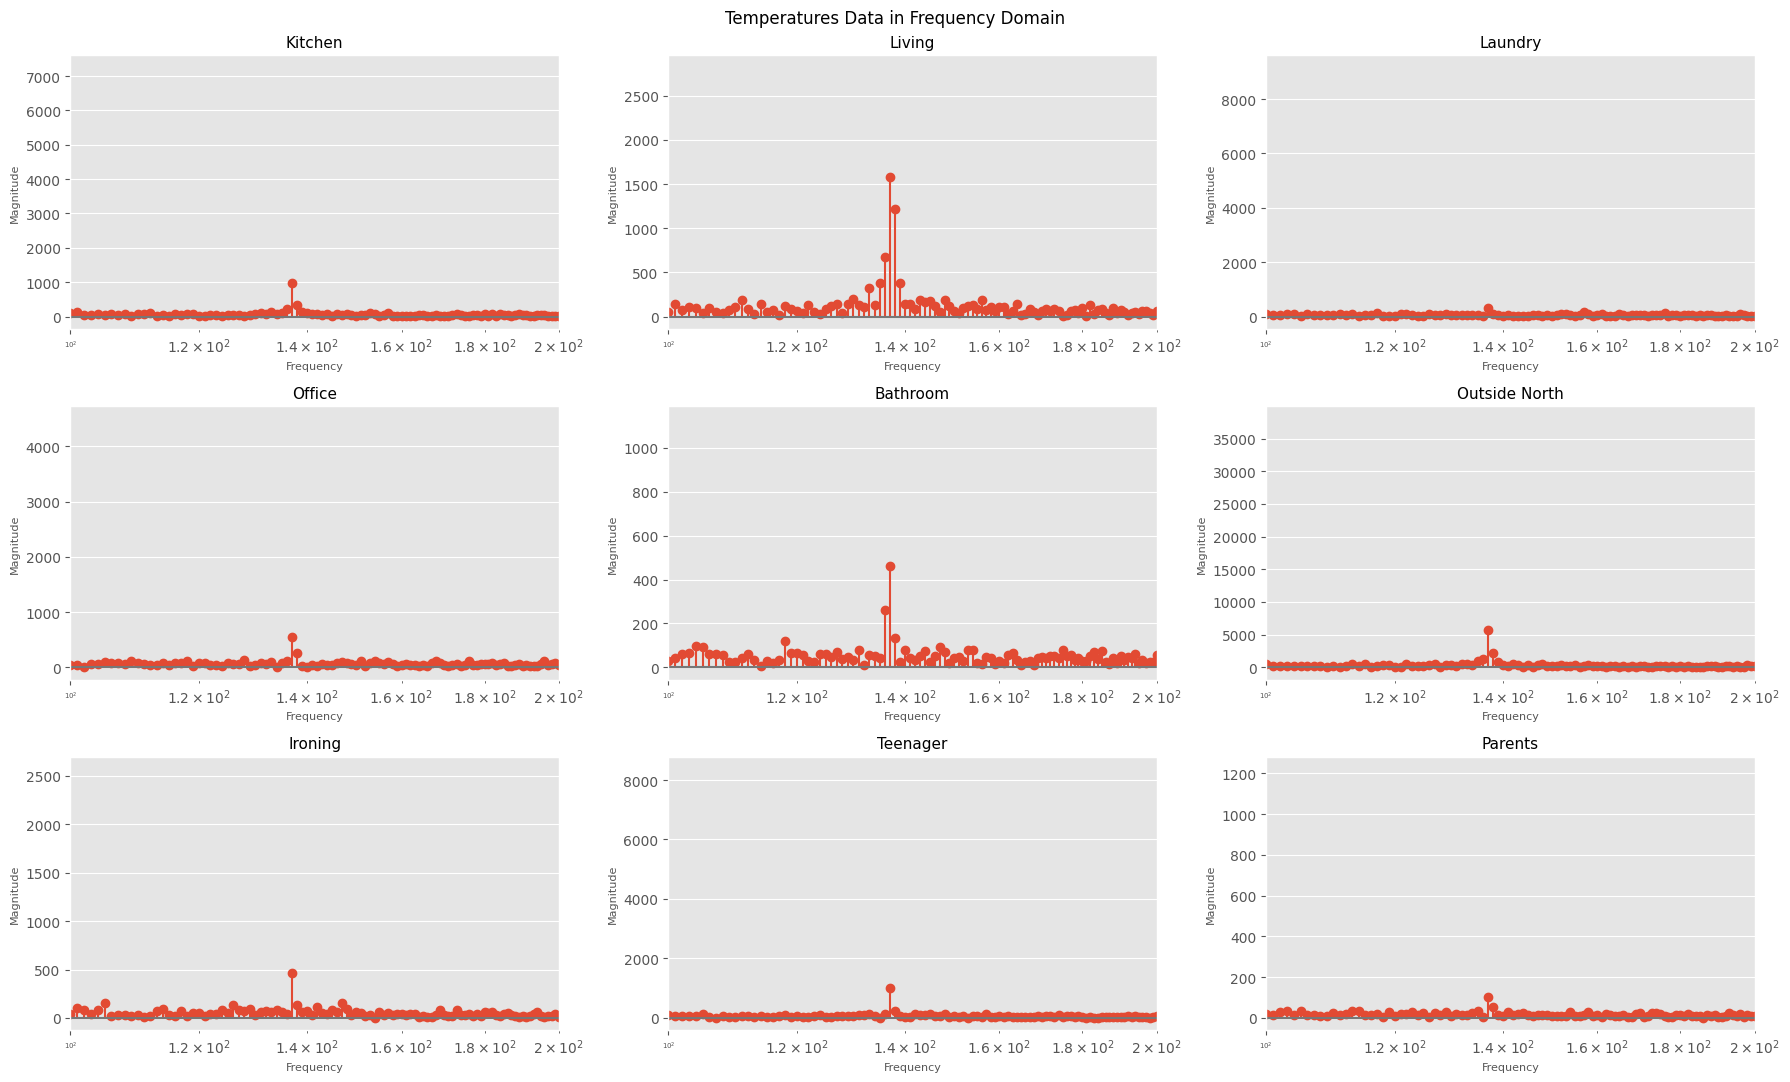

In [48]:
plt.style.use("ggplot")
figure, axis = plt.subplots(3, 3, figsize=(18, 11))

k=0
for i in range(3):
    for j in range(3):
        k+=1
        data = df_sub['T'+str(k)]
        num_samples = len(data.to_numpy())

        #dft
        fft = np.fft.rfft(data.to_numpy(), num_samples)

        axis[i,j].stem(abs(fft))
        #axis[i,j].plot(clean_data)
        axis[i,j].set_xlim(left=100, right=200)

        axis[i,j].set_title(sensors[k], fontsize=11)
        axis[i,j].set_xlabel("Frequency", fontsize=8)
        axis[i,j].set_ylabel("Magnitude", fontsize=8)
        axis[i,j].tick_params(axis="x", labelsize=5) 
        axis[i,j].set_xscale('log')

figure.suptitle("Temperatures Data in Frequency Domain")
figure.tight_layout()
plt.show()

We have low response to high frequency, as we expect higher frequency bring noise to our data. The relevant signals are the ones with longer period. This means that our data are affected by noise caused by quick variation of temperatures. In order to clean data from noise we can delete high frequency signals.

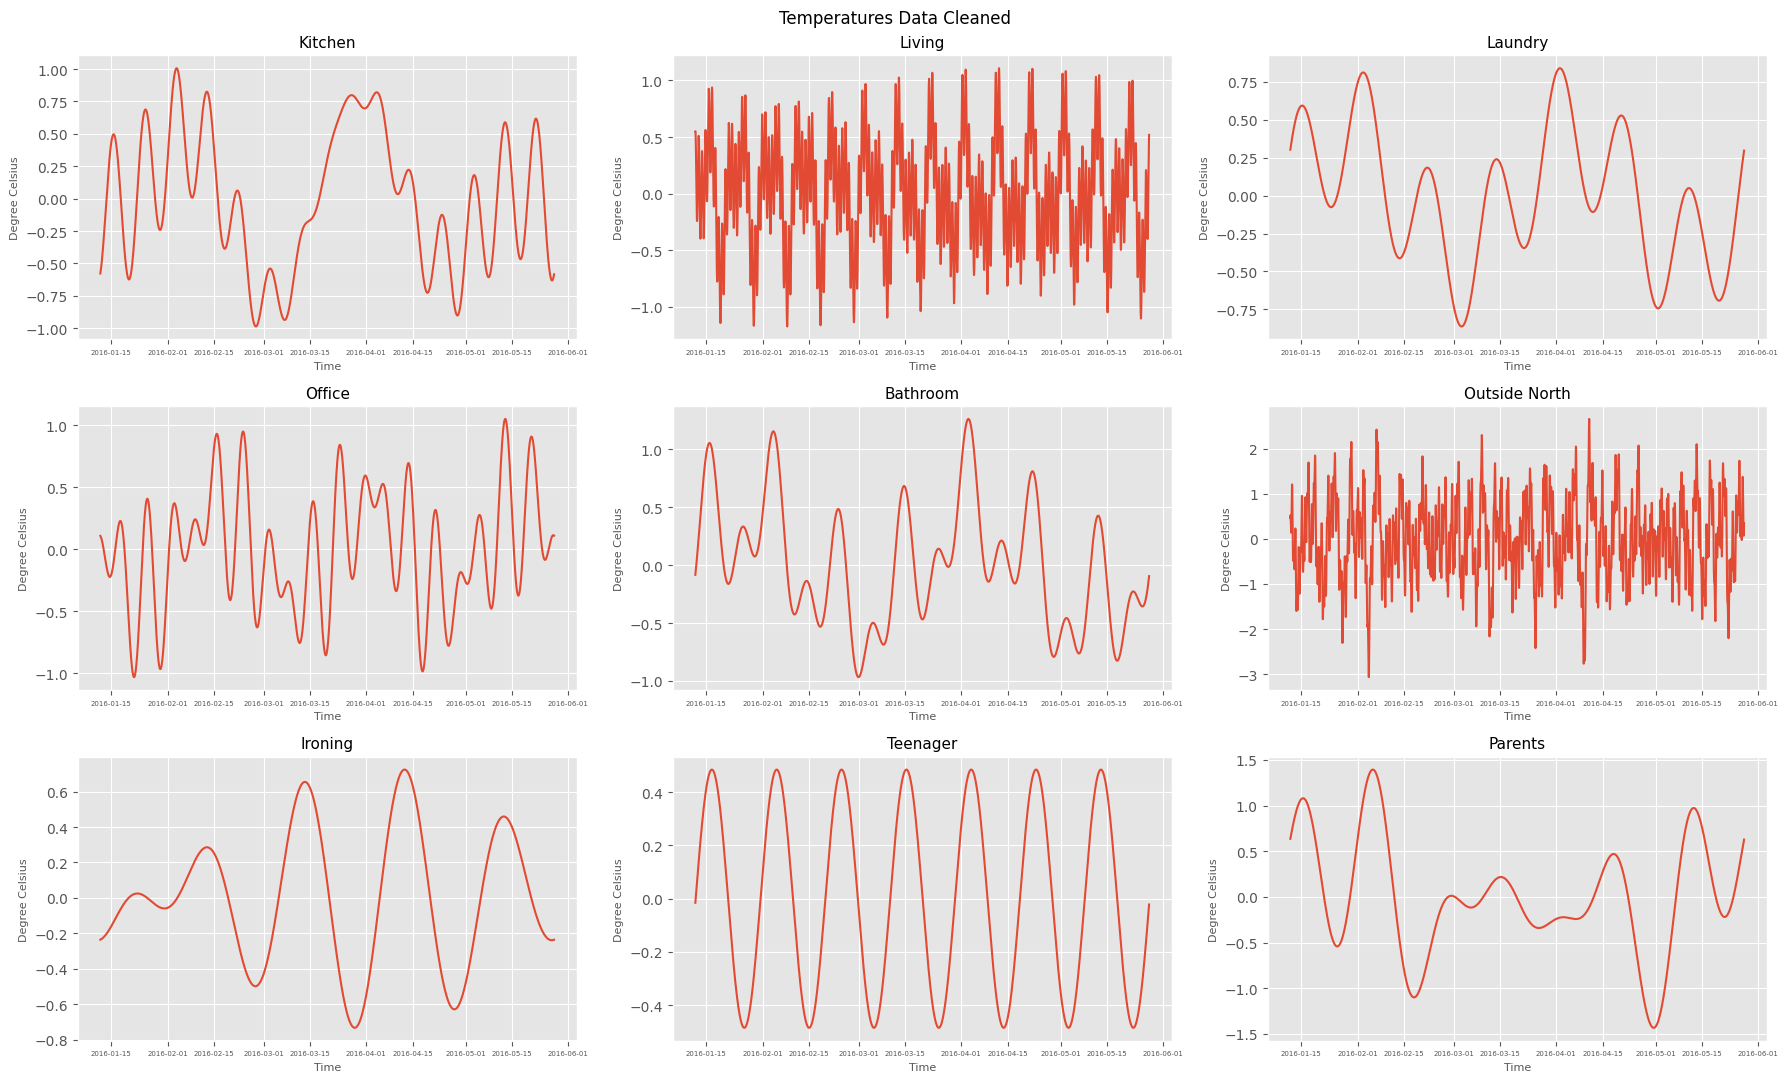

In [44]:
plt.style.use("ggplot")
figure, axis = plt.subplots(3, 3, figsize=(18, 11))

k=0
lim_sx = [50,100,100,100,100,100,100,100,50]
lim_dx = [160,150,200,200,200,200,200,200,200]

df_clean = df_sub.copy(deep=True)

for i in range(3):
    for j in range(3):
        k+=1
        data = df_sub['T'+str(k)]
        num_samples = len(data.to_numpy())

        #dft
        fft = np.fft.rfft(data.to_numpy(), num_samples)

        PSD = fft * np.conj(fft) / num_samples

        _masklow = PSD > lim_sx[k-1]
        _maskhigh = PSD < lim_dx[k-1]
        fft = _maskhigh * fft
        fft = _masklow * fft 

        df_clean['T'+str(k)]=np.fft.irfft(fft)

        #axis[i,j].stem(abs(fft[1:]))
        axis[i,j].plot(df_clean['T'+str(k)])

        axis[i,j].set_title(sensors[k], fontsize=11)
        axis[i,j].set_xlabel("Time", fontsize=8)
        axis[i,j].set_ylabel("Degree Celsius", fontsize=8)
        axis[i,j].tick_params(axis="x", labelsize=5) 
        #axis[i,j].set_xscale('log')

figure.suptitle("Temperatures Data Cleaned")
figure.tight_layout()
plt.show()

### Seasonality
From time series of house temperatures we expect the value to repeat every day, high temperature by day and low by night. Also the type of mesauration, every 10 minutes for a period of 4.5 months, lead to this type of analysis. We can also try to see if there is a monthly periodicity.

First we try with period equal a month.

In [ ]:
#Period = Month

import statsmodels.api as sm

plt.style.use("ggplot")
figure, axis = plt.subplots(3, 3, figsize=(15, 8))

k=0
for i in range(3):
    for j in range(3):
        k+=1
        data = df['T'+str(k)]
        #print(data)
        decomposition = sm.tsa.seasonal_decompose(data, period=4320) #1 day 144 , 1 month 4320
        decomposition.seasonal.plot(ax=axis[i,j])
        axis[i,j].set_title(sensors[k], fontsize=11)

figure.suptitle("Seasonality of Temperatures (Period=Month)")
figure.tight_layout()
plt.show()



Then we move to period equal a day.

In [ ]:
# Period = 1 Day 
plt.style.use("ggplot")
figure, axis = plt.subplots(3, 3, figsize=(15, 8))

k=0
for i in range(3):
    for j in range(3):
        k+=1
        data = df['T'+str(k)]
        #print(data)
        decomposition = sm.tsa.seasonal_decompose(data, period=144) 
        decomposition.seasonal["2016-03-01 00:00:00":"2016-03-10 00:00:00"].plot(ax=axis[i,j])
        axis[i,j].set_title(sensors[k], fontsize=11)

figure.suptitle("Seasonality of Temperatures (Period=Day)")
figure.tight_layout()
plt.show()

#### Trend
All the temperatures have a trend from lower to higher caused by the transition from winter to summer.

In [ ]:
plt.style.use("ggplot")
figure, axis = plt.subplots(3, 3, figsize=(15, 8))

k=0
for i in range(3):
    for j in range(3):
        k+=1
        data = df['T'+str(k)]
        #print(data)
        decomposition = sm.tsa.seasonal_decompose(data, period=4320) 
        decomposition.trend.plot(ax=axis[i,j])
        axis[i,j].set_title(sensors[k], fontsize=11)

figure.suptitle("Trends of Temperatures")
figure.tight_layout()
plt.show()

#### Noise
Data from time series have a lot of noise due to the fine grain misuration of the temperatures. In a ten minute interval temperature have small variation which make the data less readable. We can still manage to see how in the Ironing room and Office room the noise tend to deacrese moving to hotter months. In an Ironing room we can expect a quick increase of the temperature for a small amount of time, that is more relevant when the ambient temperature is lower. We observe also a strange behaviour in parents room.

In [ ]:
plt.style.use("ggplot")
figure, axis = plt.subplots(3, 3, figsize=(15, 8))

k=0
for i in range(3):
    for j in range(3):
        k+=1
        data = df['T'+str(k)]
        #print(data)
        decomposition = sm.tsa.seasonal_decompose(data, period=144) 
        decomposition.resid.plot(ax=axis[i,j])
        axis[i,j].set_title(sensors[k], fontsize=11)

figure.suptitle("Noise of Temperatures")
figure.tight_layout()
plt.show()

### Auto-correlation plot
Now we have the time series without noise, trend and subsampled so we can study their autocorrelogram. From time series of house temperatures we expect the value to repeat every day, high temperature by day and low by night. We can also took the frequency with best response from the DFT.

With a lag of 1 day

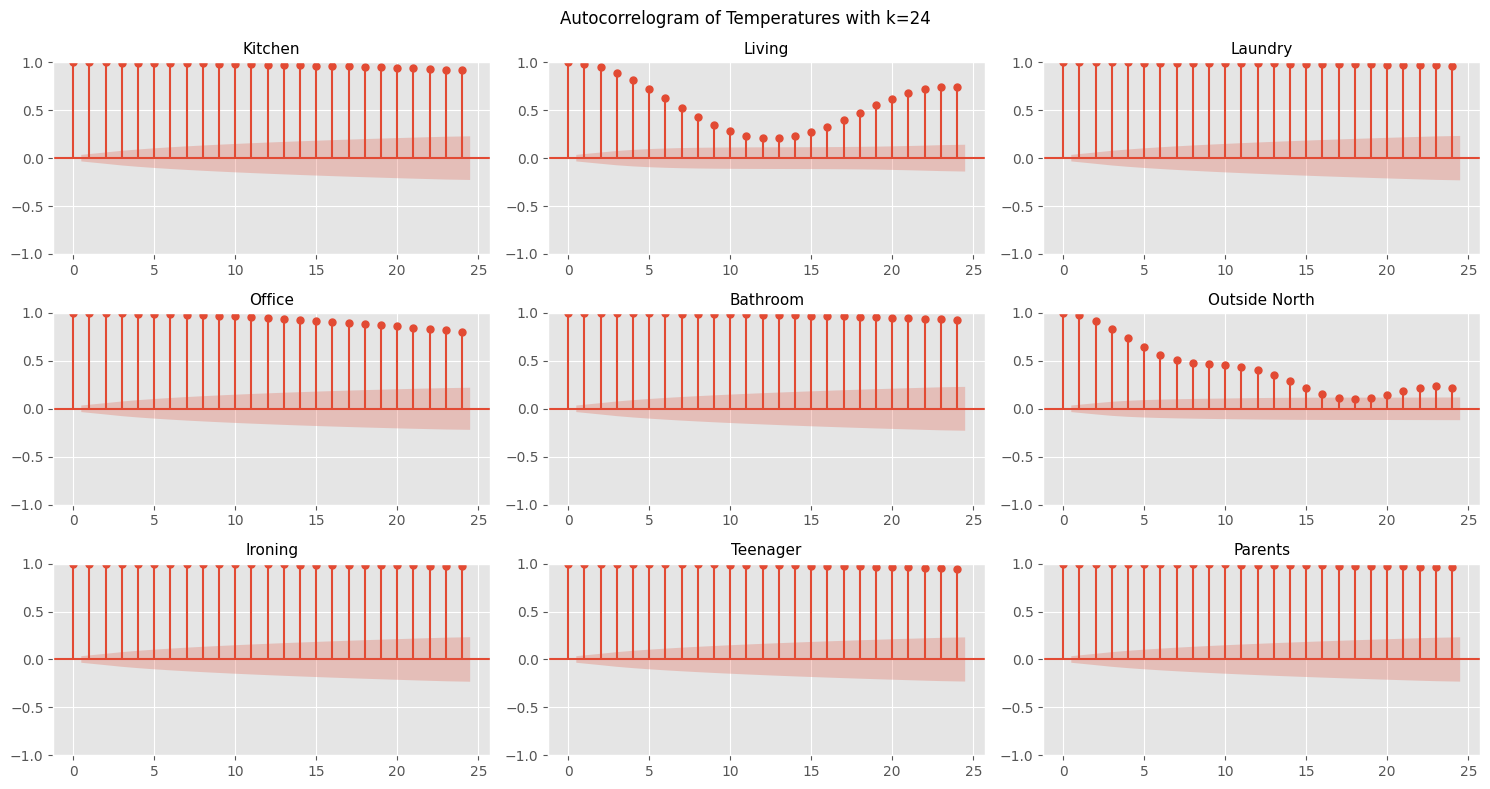

In [45]:
plt.style.use("ggplot")
figure, axis = plt.subplots(3, 3, figsize=(15, 8))

k=0
for i in range(3):
    for j in range(3):
        k+=1
        data = df_clean['T'+str(k)].to_numpy()
        tsaplots.plot_acf(data, lags = 24, ax=axis[i,j])
        axis[i,j].set_title(sensors[k], fontsize=11)

figure.suptitle("Autocorrelogram of Temperatures with k=24")
figure.tight_layout()
plt.show()


With a lag of 5 day

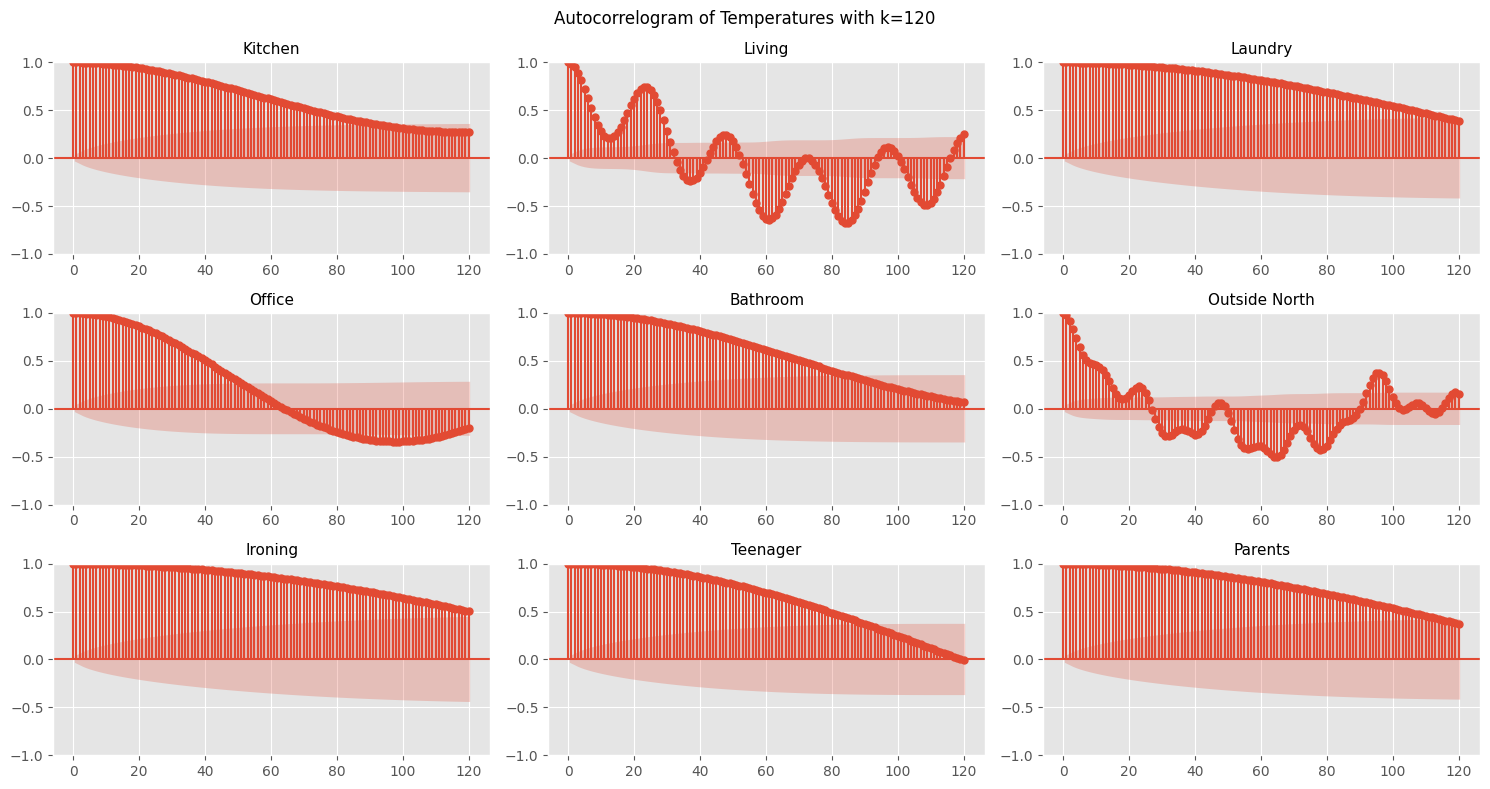

In [46]:
plt.style.use("ggplot")
figure, axis = plt.subplots(3, 3, figsize=(15, 8))

k=0
for i in range(3):
    for j in range(3):
        k+=1
        data = df_clean['T'+str(k)].to_numpy()
        # now we have 1 hour interval
        tsaplots.plot_acf(data, lags = 120, ax=axis[i,j])
        axis[i,j].set_title(sensors[k], fontsize=11)

figure.suptitle("Autocorrelogram of Temperatures with k=120")
figure.tight_layout()
plt.show()

## Result of the Analysis
- start with cleaning of data 
- plot autocorrelogram
- we can observe different behaviour with different periodicity 

## Considerations
- what you learn
- tools
- one of my favourite topic
- we can go deeper